Notes to Group:
* Normalization and transformations are from hw2 p1
* only touched up to classification


# Final Project: Pnuenomia Classification

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms,models,datasets
from sklearn.metrics import average_precision_score
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import scipy
import torchvision.models as models
from sklearn.metrics import confusion_matrix

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Reading Data

### Loading Training Data

In [2]:
# Transforms applied to the training data
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std= [0.229, 0.224, 0.225])

ds_transforms = {
        'train': transforms.Compose([
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomResizedCrop(227, scale=(0.8, 1.0)),
                    transforms.Resize(227),
                    transforms.CenterCrop(227),
                    transforms.ToTensor(),
                    normalize
                ]),
        'test': transforms.Compose([
                    transforms.Resize(227),
                    transforms.CenterCrop(227),
                    transforms.ToTensor(),
                    normalize,
                ]),
        'validate': transforms.Compose([
                    transforms.Resize(227),
                    transforms.CenterCrop(227),
                    transforms.ToTensor(),
                    normalize,
                ])
        }



### Loading Train, Test, and Validation Data

Load our pneumonia dataset into our program.

In [3]:
ds_dir = {
    'train': 'data/train',
    'test' : 'data/test',
    'validate':  'data/val',
}

ds_set = {
    'train': torchvision.datasets.ImageFolder(ds_dir['train'], ds_transforms['train']),
    'test' : torchvision.datasets.ImageFolder(ds_dir['test'], ds_transforms['test']),
    'validate':  torchvision.datasets.ImageFolder(ds_dir['validate'], ds_transforms['validate']),
}

#any higher was giving memory issues
# ds_batch_size = 16
ds_batch_size = 8
ds_loader = {
    'train': torch.utils.data.DataLoader(ds_set['train'], batch_size=ds_batch_size,shuffle=True),
    'test': torch.utils.data.DataLoader(ds_set['test'], batch_size=ds_batch_size,shuffle=True),
    'validate': torch.utils.data.DataLoader(ds_set['test'], batch_size=ds_batch_size,shuffle=True),
}
ds_class = {ds_set['validate'].class_to_idx[i]: i for i in list(ds_set['validate'].class_to_idx.keys())}

### Visualizing the Data 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


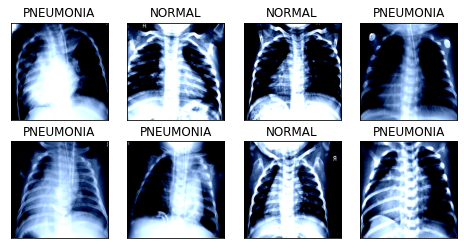

In [4]:
#display 8 images
num_images = 8

ds_iter = iter(ds_loader['train'])
images, labels = ds_iter.next()
images = images.numpy()

#show the images, set up plt
ds_figure = plt.figure(figsize=(num_images, 4))

for i in np.arange(num_images):
    ds_figure_subplot = ds_figure.add_subplot(2, num_images/2, i+1, xticks=[], yticks=[]) #remove ticks and change layout
    image = np.transpose(images[i])
    image = np.rot90(np.rot90(np.rot90(image)))#rotate images to be up right
    
    plt.imshow(image) #show image
    ds_figure_subplot.set_title(ds_class[labels.tolist()[i]]) #add title of normal or pneumonia

# Classification

In [5]:
device_is_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if device_is_gpu else "cpu")
print(device)

cuda:0


In [6]:
def train_classifier(train_loader, classifier, criterion, optimizer):
    classifier.train()
    loss_ = 0.0
    total_loss = 0.0
    batch_count = 0
    for images, labels in train_loader:
        print('Training Batch Count: ', batch_count)
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = classifier(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)
        batch_count += 1
    return total_loss

In [7]:
def validate_classifier(validate_loader, classifier, criterion):
    classifier.eval()
    number_correct = 0
    number_data = 0
    batch_count = 0
    validate_loss = 0.0
    for images, labels in validate_loader:
        print('Validating Batch Count: ', batch_count)
        images, labels = images.to(device), labels.to(device)
        logits = classifier(images)
        loss = criterion(logits, labels)
        validate_loss += loss.item() * images.size(0)
        
        #get data for accuracy
        _, pred = torch.max(logits, 1) 
        correct_tensor = pred.eq(labels.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not device_is_gpu \
                                else np.squeeze(correct_tensor.cpu().numpy())
        number_correct += sum(correct)
        number_data += correct.shape[0]
        batch_count += 1
        
    return validate_loss, number_correct, number_data

In [10]:
def test_classifier(test_loader, classifier):
    classifier.eval()
    num_correct = 0
    num_data = 0
    batch_count = 0
    num_tn, num_fp, num_fn, num_tp = 0,0,0,0
    print(device)
    for images, labels in test_loader:
        
        print('Test Batch Count: ', batch_count)
        images, labels = images.to(device), labels.to(device)
        logits = classifier(images)
        
        #get data for accuracy
        _, pred = torch.max(logits, 1) 
        correct_tensor = pred.eq(labels.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not device_is_gpu \
                                else np.squeeze(correct_tensor.cpu().numpy())
        num_correct += sum(correct)
        num_data += correct.shape[0]
        batch_count += 1
        cm = confusion_matrix(correct_tensor.tolist(), pred.tolist()).ravel()
        if len(cm)>1:
            tn, fp, fn, tp = cm
            num_tn += tn
            num_fp += fp
            num_fn += fn
            num_tp += tp
        elif pred.tolist()[0] == 0:
            num_tn += cm[0]
        elif pred.tolist()[0] == 1:
            num_tp += cm[0]
        
#         tn, fp, fn, tp = confusion_matrix(correct_tensor.tolist(), pred.tolist()).ravel()
#         num_tn += tn
#         num_fp += fp
#         num_fn += fn
#         num_tp += tp
        
    accuracy = (100 * num_correct / num_data)
    recall = num_tp/(num_tp+num_fn)
    precision = num_tp/(num_tp+num_fp)
        
    return accuracy, recall, precision, num_tn, num_fp, num_fn, num_tp

In [9]:
#classifier = models.alexnet(pretrained=True)#using this model
classifier = models.resnet50(pretrained=True)#using this model
classifier.cuda()
for param in classifier.parameters():
    param.requires_grad = True

In [10]:
#set loss function
criterion = nn.CrossEntropyLoss()
#set optimizer
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
#set scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10, gamma=0.1)

In [11]:
# Training the Classifier
NUM_EPOCHS = 40



validate_loss_min = np.Inf
for epoch in range(1, NUM_EPOCHS+1):
    print("Starting epoch number " + str(epoch))
    train_loss = train_classifier(ds_loader['train'], classifier, criterion, optimizer)
    print("Epoch Train Done for: ", epoch)
    validate_loss, num_correct, num_data = validate_classifier(ds_loader['validate'], classifier, criterion)
    print("Epoch Validate Done for: ", epoch)
    
    train_loss = train_loss / len(ds_loader['train'].dataset)
    validate_loss = validate_loss / len(ds_loader['validate'].dataset)
    accuracy = (100 * num_correct / num_data)
    
    #save model if better
    print('Epoch: {} \n-----------------\n \tTraining Loss: {:.6f} \t Validation Loss: {:.6f} \t accuracy : {:.4f}% '.format(epoch, train_loss, validate_loss,accuracy))
    if validate_loss <= validate_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(validate_loss_min,validate_loss))
            torch.save(classifier.state_dict(), 'saved_model_pretrained.pth')
            validate_loss_min = validate_loss
    scheduler.step()
    
    

Starting epoch number 1
Training Batch Count:  0
Training Batch Count:  1
Training Batch Count:  2
Training Batch Count:  3
Training Batch Count:  4
Training Batch Count:  5
Training Batch Count:  6
Training Batch Count:  7
Training Batch Count:  8
Training Batch Count:  9
Training Batch Count:  10
Training Batch Count:  11
Training Batch Count:  12
Training Batch Count:  13
Training Batch Count:  14
Training Batch Count:  15
Training Batch Count:  16
Training Batch Count:  17
Training Batch Count:  18
Training Batch Count:  19
Training Batch Count:  20
Training Batch Count:  21
Training Batch Count:  22
Training Batch Count:  23
Training Batch Count:  24
Training Batch Count:  25
Training Batch Count:  26
Training Batch Count:  27
Training Batch Count:  28
Training Batch Count:  29
Training Batch Count:  30
Training Batch Count:  31
Training Batch Count:  32
Training Batch Count:  33
Training Batch Count:  34
Training Batch Count:  35
Training Batch Count:  36
Training Batch Count:  3

Training Batch Count:  307
Training Batch Count:  308
Training Batch Count:  309
Training Batch Count:  310
Training Batch Count:  311
Training Batch Count:  312
Training Batch Count:  313
Training Batch Count:  314
Training Batch Count:  315
Training Batch Count:  316
Training Batch Count:  317
Training Batch Count:  318
Training Batch Count:  319
Training Batch Count:  320
Training Batch Count:  321
Training Batch Count:  322
Training Batch Count:  323
Training Batch Count:  324
Training Batch Count:  325
Epoch Train Done for:  1
Validating Batch Count:  0
Validating Batch Count:  1
Validating Batch Count:  2
Validating Batch Count:  3
Validating Batch Count:  4
Validating Batch Count:  5
Validating Batch Count:  6
Validating Batch Count:  7
Validating Batch Count:  8
Validating Batch Count:  9
Validating Batch Count:  10
Validating Batch Count:  11
Validating Batch Count:  12
Validating Batch Count:  13
Validating Batch Count:  14
Validating Batch Count:  15
Validating Batch Count: 

Training Batch Count:  240
Training Batch Count:  241
Training Batch Count:  242
Training Batch Count:  243
Training Batch Count:  244
Training Batch Count:  245
Training Batch Count:  246
Training Batch Count:  247
Training Batch Count:  248
Training Batch Count:  249
Training Batch Count:  250
Training Batch Count:  251
Training Batch Count:  252
Training Batch Count:  253
Training Batch Count:  254
Training Batch Count:  255
Training Batch Count:  256
Training Batch Count:  257
Training Batch Count:  258
Training Batch Count:  259
Training Batch Count:  260
Training Batch Count:  261
Training Batch Count:  262
Training Batch Count:  263
Training Batch Count:  264
Training Batch Count:  265
Training Batch Count:  266
Training Batch Count:  267
Training Batch Count:  268
Training Batch Count:  269
Training Batch Count:  270
Training Batch Count:  271
Training Batch Count:  272
Training Batch Count:  273
Training Batch Count:  274
Training Batch Count:  275
Training Batch Count:  276
T

Training Batch Count:  175
Training Batch Count:  176
Training Batch Count:  177
Training Batch Count:  178
Training Batch Count:  179
Training Batch Count:  180
Training Batch Count:  181
Training Batch Count:  182
Training Batch Count:  183
Training Batch Count:  184
Training Batch Count:  185
Training Batch Count:  186
Training Batch Count:  187
Training Batch Count:  188
Training Batch Count:  189
Training Batch Count:  190
Training Batch Count:  191
Training Batch Count:  192
Training Batch Count:  193
Training Batch Count:  194
Training Batch Count:  195
Training Batch Count:  196
Training Batch Count:  197
Training Batch Count:  198
Training Batch Count:  199
Training Batch Count:  200
Training Batch Count:  201
Training Batch Count:  202
Training Batch Count:  203
Training Batch Count:  204
Training Batch Count:  205
Training Batch Count:  206
Training Batch Count:  207
Training Batch Count:  208
Training Batch Count:  209
Training Batch Count:  210
Training Batch Count:  211
T

Training Batch Count:  108
Training Batch Count:  109
Training Batch Count:  110
Training Batch Count:  111
Training Batch Count:  112
Training Batch Count:  113
Training Batch Count:  114
Training Batch Count:  115
Training Batch Count:  116
Training Batch Count:  117
Training Batch Count:  118
Training Batch Count:  119
Training Batch Count:  120
Training Batch Count:  121
Training Batch Count:  122
Training Batch Count:  123
Training Batch Count:  124
Training Batch Count:  125
Training Batch Count:  126
Training Batch Count:  127
Training Batch Count:  128
Training Batch Count:  129
Training Batch Count:  130
Training Batch Count:  131
Training Batch Count:  132
Training Batch Count:  133
Training Batch Count:  134
Training Batch Count:  135
Training Batch Count:  136
Training Batch Count:  137
Training Batch Count:  138
Training Batch Count:  139
Training Batch Count:  140
Training Batch Count:  141
Training Batch Count:  142
Training Batch Count:  143
Training Batch Count:  144
T

Training Batch Count:  41
Training Batch Count:  42
Training Batch Count:  43
Training Batch Count:  44
Training Batch Count:  45
Training Batch Count:  46
Training Batch Count:  47
Training Batch Count:  48
Training Batch Count:  49
Training Batch Count:  50
Training Batch Count:  51
Training Batch Count:  52
Training Batch Count:  53
Training Batch Count:  54
Training Batch Count:  55
Training Batch Count:  56
Training Batch Count:  57
Training Batch Count:  58
Training Batch Count:  59
Training Batch Count:  60
Training Batch Count:  61
Training Batch Count:  62
Training Batch Count:  63
Training Batch Count:  64
Training Batch Count:  65
Training Batch Count:  66
Training Batch Count:  67
Training Batch Count:  68
Training Batch Count:  69
Training Batch Count:  70
Training Batch Count:  71
Training Batch Count:  72
Training Batch Count:  73
Training Batch Count:  74
Training Batch Count:  75
Training Batch Count:  76
Training Batch Count:  77
Training Batch Count:  78
Training Bat

Validating Batch Count:  20
Validating Batch Count:  21
Validating Batch Count:  22
Validating Batch Count:  23
Validating Batch Count:  24
Validating Batch Count:  25
Validating Batch Count:  26
Validating Batch Count:  27
Validating Batch Count:  28
Validating Batch Count:  29
Validating Batch Count:  30
Validating Batch Count:  31
Validating Batch Count:  32
Validating Batch Count:  33
Validating Batch Count:  34
Validating Batch Count:  35
Validating Batch Count:  36
Validating Batch Count:  37
Validating Batch Count:  38
Epoch Validate Done for:  5
Epoch: 5 
-----------------
 	Training Loss: 0.105783 	 Validation Loss: 0.374885 	 accuracy : 87.6603% 
Starting epoch number 6
Training Batch Count:  0
Training Batch Count:  1
Training Batch Count:  2
Training Batch Count:  3
Training Batch Count:  4
Training Batch Count:  5
Training Batch Count:  6
Training Batch Count:  7
Training Batch Count:  8
Training Batch Count:  9
Training Batch Count:  10
Training Batch Count:  11
Training 

Training Batch Count:  282
Training Batch Count:  283
Training Batch Count:  284
Training Batch Count:  285
Training Batch Count:  286
Training Batch Count:  287
Training Batch Count:  288
Training Batch Count:  289
Training Batch Count:  290
Training Batch Count:  291
Training Batch Count:  292
Training Batch Count:  293
Training Batch Count:  294
Training Batch Count:  295
Training Batch Count:  296
Training Batch Count:  297
Training Batch Count:  298
Training Batch Count:  299
Training Batch Count:  300
Training Batch Count:  301
Training Batch Count:  302
Training Batch Count:  303
Training Batch Count:  304
Training Batch Count:  305
Training Batch Count:  306
Training Batch Count:  307
Training Batch Count:  308
Training Batch Count:  309
Training Batch Count:  310
Training Batch Count:  311
Training Batch Count:  312
Training Batch Count:  313
Training Batch Count:  314
Training Batch Count:  315
Training Batch Count:  316
Training Batch Count:  317
Training Batch Count:  318
T

Training Batch Count:  217
Training Batch Count:  218
Training Batch Count:  219
Training Batch Count:  220
Training Batch Count:  221
Training Batch Count:  222
Training Batch Count:  223
Training Batch Count:  224
Training Batch Count:  225
Training Batch Count:  226
Training Batch Count:  227
Training Batch Count:  228
Training Batch Count:  229
Training Batch Count:  230
Training Batch Count:  231
Training Batch Count:  232
Training Batch Count:  233
Training Batch Count:  234
Training Batch Count:  235
Training Batch Count:  236
Training Batch Count:  237
Training Batch Count:  238
Training Batch Count:  239
Training Batch Count:  240
Training Batch Count:  241
Training Batch Count:  242
Training Batch Count:  243
Training Batch Count:  244
Training Batch Count:  245
Training Batch Count:  246
Training Batch Count:  247
Training Batch Count:  248
Training Batch Count:  249
Training Batch Count:  250
Training Batch Count:  251
Training Batch Count:  252
Training Batch Count:  253
T

Training Batch Count:  152
Training Batch Count:  153
Training Batch Count:  154
Training Batch Count:  155
Training Batch Count:  156
Training Batch Count:  157
Training Batch Count:  158
Training Batch Count:  159
Training Batch Count:  160
Training Batch Count:  161
Training Batch Count:  162
Training Batch Count:  163
Training Batch Count:  164
Training Batch Count:  165
Training Batch Count:  166
Training Batch Count:  167
Training Batch Count:  168
Training Batch Count:  169
Training Batch Count:  170
Training Batch Count:  171
Training Batch Count:  172
Training Batch Count:  173
Training Batch Count:  174
Training Batch Count:  175
Training Batch Count:  176
Training Batch Count:  177
Training Batch Count:  178
Training Batch Count:  179
Training Batch Count:  180
Training Batch Count:  181
Training Batch Count:  182
Training Batch Count:  183
Training Batch Count:  184
Training Batch Count:  185
Training Batch Count:  186
Training Batch Count:  187
Training Batch Count:  188
T

Training Batch Count:  84
Training Batch Count:  85
Training Batch Count:  86
Training Batch Count:  87
Training Batch Count:  88
Training Batch Count:  89
Training Batch Count:  90
Training Batch Count:  91
Training Batch Count:  92
Training Batch Count:  93
Training Batch Count:  94
Training Batch Count:  95
Training Batch Count:  96
Training Batch Count:  97
Training Batch Count:  98
Training Batch Count:  99
Training Batch Count:  100
Training Batch Count:  101
Training Batch Count:  102
Training Batch Count:  103
Training Batch Count:  104
Training Batch Count:  105
Training Batch Count:  106
Training Batch Count:  107
Training Batch Count:  108
Training Batch Count:  109
Training Batch Count:  110
Training Batch Count:  111
Training Batch Count:  112
Training Batch Count:  113
Training Batch Count:  114
Training Batch Count:  115
Training Batch Count:  116
Training Batch Count:  117
Training Batch Count:  118
Training Batch Count:  119
Training Batch Count:  120
Training Batch Co

Training Batch Count:  17
Training Batch Count:  18
Training Batch Count:  19
Training Batch Count:  20
Training Batch Count:  21
Training Batch Count:  22
Training Batch Count:  23
Training Batch Count:  24
Training Batch Count:  25
Training Batch Count:  26
Training Batch Count:  27
Training Batch Count:  28
Training Batch Count:  29
Training Batch Count:  30
Training Batch Count:  31
Training Batch Count:  32
Training Batch Count:  33
Training Batch Count:  34
Training Batch Count:  35
Training Batch Count:  36
Training Batch Count:  37
Training Batch Count:  38
Training Batch Count:  39
Training Batch Count:  40
Training Batch Count:  41
Training Batch Count:  42
Training Batch Count:  43
Training Batch Count:  44
Training Batch Count:  45
Training Batch Count:  46
Training Batch Count:  47
Training Batch Count:  48
Training Batch Count:  49
Training Batch Count:  50
Training Batch Count:  51
Training Batch Count:  52
Training Batch Count:  53
Training Batch Count:  54
Training Bat

Training Batch Count:  324
Training Batch Count:  325
Epoch Train Done for:  10
Validating Batch Count:  0
Validating Batch Count:  1
Validating Batch Count:  2
Validating Batch Count:  3
Validating Batch Count:  4
Validating Batch Count:  5
Validating Batch Count:  6
Validating Batch Count:  7
Validating Batch Count:  8
Validating Batch Count:  9
Validating Batch Count:  10
Validating Batch Count:  11
Validating Batch Count:  12
Validating Batch Count:  13
Validating Batch Count:  14
Validating Batch Count:  15
Validating Batch Count:  16
Validating Batch Count:  17
Validating Batch Count:  18
Validating Batch Count:  19
Validating Batch Count:  20
Validating Batch Count:  21
Validating Batch Count:  22
Validating Batch Count:  23
Validating Batch Count:  24
Validating Batch Count:  25
Validating Batch Count:  26
Validating Batch Count:  27
Validating Batch Count:  28
Validating Batch Count:  29
Validating Batch Count:  30
Validating Batch Count:  31
Validating Batch Count:  32
Valida

Training Batch Count:  259
Training Batch Count:  260
Training Batch Count:  261
Training Batch Count:  262
Training Batch Count:  263
Training Batch Count:  264
Training Batch Count:  265
Training Batch Count:  266
Training Batch Count:  267
Training Batch Count:  268
Training Batch Count:  269
Training Batch Count:  270
Training Batch Count:  271
Training Batch Count:  272
Training Batch Count:  273
Training Batch Count:  274
Training Batch Count:  275
Training Batch Count:  276
Training Batch Count:  277
Training Batch Count:  278
Training Batch Count:  279
Training Batch Count:  280
Training Batch Count:  281
Training Batch Count:  282
Training Batch Count:  283
Training Batch Count:  284
Training Batch Count:  285
Training Batch Count:  286
Training Batch Count:  287
Training Batch Count:  288
Training Batch Count:  289
Training Batch Count:  290
Training Batch Count:  291
Training Batch Count:  292
Training Batch Count:  293
Training Batch Count:  294
Training Batch Count:  295
T

Training Batch Count:  194
Training Batch Count:  195
Training Batch Count:  196
Training Batch Count:  197
Training Batch Count:  198
Training Batch Count:  199
Training Batch Count:  200
Training Batch Count:  201
Training Batch Count:  202
Training Batch Count:  203
Training Batch Count:  204
Training Batch Count:  205
Training Batch Count:  206
Training Batch Count:  207
Training Batch Count:  208
Training Batch Count:  209
Training Batch Count:  210
Training Batch Count:  211
Training Batch Count:  212
Training Batch Count:  213
Training Batch Count:  214
Training Batch Count:  215
Training Batch Count:  216
Training Batch Count:  217
Training Batch Count:  218
Training Batch Count:  219
Training Batch Count:  220
Training Batch Count:  221
Training Batch Count:  222
Training Batch Count:  223
Training Batch Count:  224
Training Batch Count:  225
Training Batch Count:  226
Training Batch Count:  227
Training Batch Count:  228
Training Batch Count:  229
Training Batch Count:  230
T

Training Batch Count:  129
Training Batch Count:  130
Training Batch Count:  131
Training Batch Count:  132
Training Batch Count:  133
Training Batch Count:  134
Training Batch Count:  135
Training Batch Count:  136
Training Batch Count:  137
Training Batch Count:  138
Training Batch Count:  139
Training Batch Count:  140
Training Batch Count:  141
Training Batch Count:  142
Training Batch Count:  143
Training Batch Count:  144
Training Batch Count:  145
Training Batch Count:  146
Training Batch Count:  147
Training Batch Count:  148
Training Batch Count:  149
Training Batch Count:  150
Training Batch Count:  151
Training Batch Count:  152
Training Batch Count:  153
Training Batch Count:  154
Training Batch Count:  155
Training Batch Count:  156
Training Batch Count:  157
Training Batch Count:  158
Training Batch Count:  159
Training Batch Count:  160
Training Batch Count:  161
Training Batch Count:  162
Training Batch Count:  163
Training Batch Count:  164
Training Batch Count:  165
T

Training Batch Count:  63
Training Batch Count:  64
Training Batch Count:  65
Training Batch Count:  66
Training Batch Count:  67
Training Batch Count:  68
Training Batch Count:  69
Training Batch Count:  70
Training Batch Count:  71
Training Batch Count:  72
Training Batch Count:  73
Training Batch Count:  74
Training Batch Count:  75
Training Batch Count:  76
Training Batch Count:  77
Training Batch Count:  78
Training Batch Count:  79
Training Batch Count:  80
Training Batch Count:  81
Training Batch Count:  82
Training Batch Count:  83
Training Batch Count:  84
Training Batch Count:  85
Training Batch Count:  86
Training Batch Count:  87
Training Batch Count:  88
Training Batch Count:  89
Training Batch Count:  90
Training Batch Count:  91
Training Batch Count:  92
Training Batch Count:  93
Training Batch Count:  94
Training Batch Count:  95
Training Batch Count:  96
Training Batch Count:  97
Training Batch Count:  98
Training Batch Count:  99
Training Batch Count:  100
Training Ba

Training Batch Count:  0
Training Batch Count:  1
Training Batch Count:  2
Training Batch Count:  3
Training Batch Count:  4
Training Batch Count:  5
Training Batch Count:  6
Training Batch Count:  7
Training Batch Count:  8
Training Batch Count:  9
Training Batch Count:  10
Training Batch Count:  11
Training Batch Count:  12
Training Batch Count:  13
Training Batch Count:  14
Training Batch Count:  15
Training Batch Count:  16
Training Batch Count:  17
Training Batch Count:  18
Training Batch Count:  19
Training Batch Count:  20
Training Batch Count:  21
Training Batch Count:  22
Training Batch Count:  23
Training Batch Count:  24
Training Batch Count:  25
Training Batch Count:  26
Training Batch Count:  27
Training Batch Count:  28
Training Batch Count:  29
Training Batch Count:  30
Training Batch Count:  31
Training Batch Count:  32
Training Batch Count:  33
Training Batch Count:  34
Training Batch Count:  35
Training Batch Count:  36
Training Batch Count:  37
Training Batch Count: 

Training Batch Count:  308
Training Batch Count:  309
Training Batch Count:  310
Training Batch Count:  311
Training Batch Count:  312
Training Batch Count:  313
Training Batch Count:  314
Training Batch Count:  315
Training Batch Count:  316
Training Batch Count:  317
Training Batch Count:  318
Training Batch Count:  319
Training Batch Count:  320
Training Batch Count:  321
Training Batch Count:  322
Training Batch Count:  323
Training Batch Count:  324
Training Batch Count:  325
Epoch Train Done for:  15
Validating Batch Count:  0
Validating Batch Count:  1
Validating Batch Count:  2
Validating Batch Count:  3
Validating Batch Count:  4
Validating Batch Count:  5
Validating Batch Count:  6
Validating Batch Count:  7
Validating Batch Count:  8
Validating Batch Count:  9
Validating Batch Count:  10
Validating Batch Count:  11
Validating Batch Count:  12
Validating Batch Count:  13
Validating Batch Count:  14
Validating Batch Count:  15
Validating Batch Count:  16
Validating Batch Count

Training Batch Count:  243
Training Batch Count:  244
Training Batch Count:  245
Training Batch Count:  246
Training Batch Count:  247
Training Batch Count:  248
Training Batch Count:  249
Training Batch Count:  250
Training Batch Count:  251
Training Batch Count:  252
Training Batch Count:  253
Training Batch Count:  254
Training Batch Count:  255
Training Batch Count:  256
Training Batch Count:  257
Training Batch Count:  258
Training Batch Count:  259
Training Batch Count:  260
Training Batch Count:  261
Training Batch Count:  262
Training Batch Count:  263
Training Batch Count:  264
Training Batch Count:  265
Training Batch Count:  266
Training Batch Count:  267
Training Batch Count:  268
Training Batch Count:  269
Training Batch Count:  270
Training Batch Count:  271
Training Batch Count:  272
Training Batch Count:  273
Training Batch Count:  274
Training Batch Count:  275
Training Batch Count:  276
Training Batch Count:  277
Training Batch Count:  278
Training Batch Count:  279
T

Training Batch Count:  178
Training Batch Count:  179
Training Batch Count:  180
Training Batch Count:  181
Training Batch Count:  182
Training Batch Count:  183
Training Batch Count:  184
Training Batch Count:  185
Training Batch Count:  186
Training Batch Count:  187
Training Batch Count:  188
Training Batch Count:  189
Training Batch Count:  190
Training Batch Count:  191
Training Batch Count:  192
Training Batch Count:  193
Training Batch Count:  194
Training Batch Count:  195
Training Batch Count:  196
Training Batch Count:  197
Training Batch Count:  198
Training Batch Count:  199
Training Batch Count:  200
Training Batch Count:  201
Training Batch Count:  202
Training Batch Count:  203
Training Batch Count:  204
Training Batch Count:  205
Training Batch Count:  206
Training Batch Count:  207
Training Batch Count:  208
Training Batch Count:  209
Training Batch Count:  210
Training Batch Count:  211
Training Batch Count:  212
Training Batch Count:  213
Training Batch Count:  214
T

Training Batch Count:  113
Training Batch Count:  114
Training Batch Count:  115
Training Batch Count:  116
Training Batch Count:  117
Training Batch Count:  118
Training Batch Count:  119
Training Batch Count:  120
Training Batch Count:  121
Training Batch Count:  122
Training Batch Count:  123
Training Batch Count:  124
Training Batch Count:  125
Training Batch Count:  126
Training Batch Count:  127
Training Batch Count:  128
Training Batch Count:  129
Training Batch Count:  130
Training Batch Count:  131
Training Batch Count:  132
Training Batch Count:  133
Training Batch Count:  134
Training Batch Count:  135
Training Batch Count:  136
Training Batch Count:  137
Training Batch Count:  138
Training Batch Count:  139
Training Batch Count:  140
Training Batch Count:  141
Training Batch Count:  142
Training Batch Count:  143
Training Batch Count:  144
Training Batch Count:  145
Training Batch Count:  146
Training Batch Count:  147
Training Batch Count:  148
Training Batch Count:  149
T

Training Batch Count:  46
Training Batch Count:  47
Training Batch Count:  48
Training Batch Count:  49
Training Batch Count:  50
Training Batch Count:  51
Training Batch Count:  52
Training Batch Count:  53
Training Batch Count:  54
Training Batch Count:  55
Training Batch Count:  56
Training Batch Count:  57
Training Batch Count:  58
Training Batch Count:  59
Training Batch Count:  60
Training Batch Count:  61
Training Batch Count:  62
Training Batch Count:  63
Training Batch Count:  64
Training Batch Count:  65
Training Batch Count:  66
Training Batch Count:  67
Training Batch Count:  68
Training Batch Count:  69
Training Batch Count:  70
Training Batch Count:  71
Training Batch Count:  72
Training Batch Count:  73
Training Batch Count:  74
Training Batch Count:  75
Training Batch Count:  76
Training Batch Count:  77
Training Batch Count:  78
Training Batch Count:  79
Training Batch Count:  80
Training Batch Count:  81
Training Batch Count:  82
Training Batch Count:  83
Training Bat

Validating Batch Count:  24
Validating Batch Count:  25
Validating Batch Count:  26
Validating Batch Count:  27
Validating Batch Count:  28
Validating Batch Count:  29
Validating Batch Count:  30
Validating Batch Count:  31
Validating Batch Count:  32
Validating Batch Count:  33
Validating Batch Count:  34
Validating Batch Count:  35
Validating Batch Count:  36
Validating Batch Count:  37
Validating Batch Count:  38
Epoch Validate Done for:  19
Epoch: 19 
-----------------
 	Training Loss: 0.028038 	 Validation Loss: 0.594928 	 accuracy : 86.3782% 
Starting epoch number 20
Training Batch Count:  0
Training Batch Count:  1
Training Batch Count:  2
Training Batch Count:  3
Training Batch Count:  4
Training Batch Count:  5
Training Batch Count:  6
Training Batch Count:  7
Training Batch Count:  8
Training Batch Count:  9
Training Batch Count:  10
Training Batch Count:  11
Training Batch Count:  12
Training Batch Count:  13
Training Batch Count:  14
Training Batch Count:  15
Training Batch

Training Batch Count:  287
Training Batch Count:  288
Training Batch Count:  289
Training Batch Count:  290
Training Batch Count:  291
Training Batch Count:  292
Training Batch Count:  293
Training Batch Count:  294
Training Batch Count:  295
Training Batch Count:  296
Training Batch Count:  297
Training Batch Count:  298
Training Batch Count:  299
Training Batch Count:  300
Training Batch Count:  301
Training Batch Count:  302
Training Batch Count:  303
Training Batch Count:  304
Training Batch Count:  305
Training Batch Count:  306
Training Batch Count:  307
Training Batch Count:  308
Training Batch Count:  309
Training Batch Count:  310
Training Batch Count:  311
Training Batch Count:  312
Training Batch Count:  313
Training Batch Count:  314
Training Batch Count:  315
Training Batch Count:  316
Training Batch Count:  317
Training Batch Count:  318
Training Batch Count:  319
Training Batch Count:  320
Training Batch Count:  321
Training Batch Count:  322
Training Batch Count:  323
T

Training Batch Count:  222
Training Batch Count:  223
Training Batch Count:  224
Training Batch Count:  225
Training Batch Count:  226
Training Batch Count:  227
Training Batch Count:  228
Training Batch Count:  229
Training Batch Count:  230
Training Batch Count:  231
Training Batch Count:  232
Training Batch Count:  233
Training Batch Count:  234
Training Batch Count:  235
Training Batch Count:  236
Training Batch Count:  237
Training Batch Count:  238
Training Batch Count:  239
Training Batch Count:  240
Training Batch Count:  241
Training Batch Count:  242
Training Batch Count:  243
Training Batch Count:  244
Training Batch Count:  245
Training Batch Count:  246
Training Batch Count:  247
Training Batch Count:  248
Training Batch Count:  249
Training Batch Count:  250
Training Batch Count:  251
Training Batch Count:  252
Training Batch Count:  253
Training Batch Count:  254
Training Batch Count:  255
Training Batch Count:  256
Training Batch Count:  257
Training Batch Count:  258
T

Training Batch Count:  157
Training Batch Count:  158
Training Batch Count:  159
Training Batch Count:  160
Training Batch Count:  161
Training Batch Count:  162
Training Batch Count:  163
Training Batch Count:  164
Training Batch Count:  165
Training Batch Count:  166
Training Batch Count:  167
Training Batch Count:  168
Training Batch Count:  169
Training Batch Count:  170
Training Batch Count:  171
Training Batch Count:  172
Training Batch Count:  173
Training Batch Count:  174
Training Batch Count:  175
Training Batch Count:  176
Training Batch Count:  177
Training Batch Count:  178
Training Batch Count:  179
Training Batch Count:  180
Training Batch Count:  181
Training Batch Count:  182
Training Batch Count:  183
Training Batch Count:  184
Training Batch Count:  185
Training Batch Count:  186
Training Batch Count:  187
Training Batch Count:  188
Training Batch Count:  189
Training Batch Count:  190
Training Batch Count:  191
Training Batch Count:  192
Training Batch Count:  193
T

Training Batch Count:  92
Training Batch Count:  93
Training Batch Count:  94
Training Batch Count:  95
Training Batch Count:  96
Training Batch Count:  97
Training Batch Count:  98
Training Batch Count:  99
Training Batch Count:  100
Training Batch Count:  101
Training Batch Count:  102
Training Batch Count:  103
Training Batch Count:  104
Training Batch Count:  105
Training Batch Count:  106
Training Batch Count:  107
Training Batch Count:  108
Training Batch Count:  109
Training Batch Count:  110
Training Batch Count:  111
Training Batch Count:  112
Training Batch Count:  113
Training Batch Count:  114
Training Batch Count:  115
Training Batch Count:  116
Training Batch Count:  117
Training Batch Count:  118
Training Batch Count:  119
Training Batch Count:  120
Training Batch Count:  121
Training Batch Count:  122
Training Batch Count:  123
Training Batch Count:  124
Training Batch Count:  125
Training Batch Count:  126
Training Batch Count:  127
Training Batch Count:  128
Training 

Training Batch Count:  25
Training Batch Count:  26
Training Batch Count:  27
Training Batch Count:  28
Training Batch Count:  29
Training Batch Count:  30
Training Batch Count:  31
Training Batch Count:  32
Training Batch Count:  33
Training Batch Count:  34
Training Batch Count:  35
Training Batch Count:  36
Training Batch Count:  37
Training Batch Count:  38
Training Batch Count:  39
Training Batch Count:  40
Training Batch Count:  41
Training Batch Count:  42
Training Batch Count:  43
Training Batch Count:  44
Training Batch Count:  45
Training Batch Count:  46
Training Batch Count:  47
Training Batch Count:  48
Training Batch Count:  49
Training Batch Count:  50
Training Batch Count:  51
Training Batch Count:  52
Training Batch Count:  53
Training Batch Count:  54
Training Batch Count:  55
Training Batch Count:  56
Training Batch Count:  57
Training Batch Count:  58
Training Batch Count:  59
Training Batch Count:  60
Training Batch Count:  61
Training Batch Count:  62
Training Bat

Validating Batch Count:  5
Validating Batch Count:  6
Validating Batch Count:  7
Validating Batch Count:  8
Validating Batch Count:  9
Validating Batch Count:  10
Validating Batch Count:  11
Validating Batch Count:  12
Validating Batch Count:  13
Validating Batch Count:  14
Validating Batch Count:  15
Validating Batch Count:  16
Validating Batch Count:  17
Validating Batch Count:  18
Validating Batch Count:  19
Validating Batch Count:  20
Validating Batch Count:  21
Validating Batch Count:  22
Validating Batch Count:  23
Validating Batch Count:  24
Validating Batch Count:  25
Validating Batch Count:  26
Validating Batch Count:  27
Validating Batch Count:  28
Validating Batch Count:  29
Validating Batch Count:  30
Validating Batch Count:  31
Validating Batch Count:  32
Validating Batch Count:  33
Validating Batch Count:  34
Validating Batch Count:  35
Validating Batch Count:  36
Validating Batch Count:  37
Validating Batch Count:  38
Epoch Validate Done for:  24
Epoch: 24 
-------------

Training Batch Count:  267
Training Batch Count:  268
Training Batch Count:  269
Training Batch Count:  270
Training Batch Count:  271
Training Batch Count:  272
Training Batch Count:  273
Training Batch Count:  274
Training Batch Count:  275
Training Batch Count:  276
Training Batch Count:  277
Training Batch Count:  278
Training Batch Count:  279
Training Batch Count:  280
Training Batch Count:  281
Training Batch Count:  282
Training Batch Count:  283
Training Batch Count:  284
Training Batch Count:  285
Training Batch Count:  286
Training Batch Count:  287
Training Batch Count:  288
Training Batch Count:  289
Training Batch Count:  290
Training Batch Count:  291
Training Batch Count:  292
Training Batch Count:  293
Training Batch Count:  294
Training Batch Count:  295
Training Batch Count:  296
Training Batch Count:  297
Training Batch Count:  298
Training Batch Count:  299
Training Batch Count:  300
Training Batch Count:  301
Training Batch Count:  302
Training Batch Count:  303
T

Training Batch Count:  202
Training Batch Count:  203
Training Batch Count:  204
Training Batch Count:  205
Training Batch Count:  206
Training Batch Count:  207
Training Batch Count:  208
Training Batch Count:  209
Training Batch Count:  210
Training Batch Count:  211
Training Batch Count:  212
Training Batch Count:  213
Training Batch Count:  214
Training Batch Count:  215
Training Batch Count:  216
Training Batch Count:  217
Training Batch Count:  218
Training Batch Count:  219
Training Batch Count:  220
Training Batch Count:  221
Training Batch Count:  222
Training Batch Count:  223
Training Batch Count:  224
Training Batch Count:  225
Training Batch Count:  226
Training Batch Count:  227
Training Batch Count:  228
Training Batch Count:  229
Training Batch Count:  230
Training Batch Count:  231
Training Batch Count:  232
Training Batch Count:  233
Training Batch Count:  234
Training Batch Count:  235
Training Batch Count:  236
Training Batch Count:  237
Training Batch Count:  238
T

Training Batch Count:  137
Training Batch Count:  138
Training Batch Count:  139
Training Batch Count:  140
Training Batch Count:  141
Training Batch Count:  142
Training Batch Count:  143
Training Batch Count:  144
Training Batch Count:  145
Training Batch Count:  146
Training Batch Count:  147
Training Batch Count:  148
Training Batch Count:  149
Training Batch Count:  150
Training Batch Count:  151
Training Batch Count:  152
Training Batch Count:  153
Training Batch Count:  154
Training Batch Count:  155
Training Batch Count:  156
Training Batch Count:  157
Training Batch Count:  158
Training Batch Count:  159
Training Batch Count:  160
Training Batch Count:  161
Training Batch Count:  162
Training Batch Count:  163
Training Batch Count:  164
Training Batch Count:  165
Training Batch Count:  166
Training Batch Count:  167
Training Batch Count:  168
Training Batch Count:  169
Training Batch Count:  170
Training Batch Count:  171
Training Batch Count:  172
Training Batch Count:  173
T

Training Batch Count:  71
Training Batch Count:  72
Training Batch Count:  73
Training Batch Count:  74
Training Batch Count:  75
Training Batch Count:  76
Training Batch Count:  77
Training Batch Count:  78
Training Batch Count:  79
Training Batch Count:  80
Training Batch Count:  81
Training Batch Count:  82
Training Batch Count:  83
Training Batch Count:  84
Training Batch Count:  85
Training Batch Count:  86
Training Batch Count:  87
Training Batch Count:  88
Training Batch Count:  89
Training Batch Count:  90
Training Batch Count:  91
Training Batch Count:  92
Training Batch Count:  93
Training Batch Count:  94
Training Batch Count:  95
Training Batch Count:  96
Training Batch Count:  97
Training Batch Count:  98
Training Batch Count:  99
Training Batch Count:  100
Training Batch Count:  101
Training Batch Count:  102
Training Batch Count:  103
Training Batch Count:  104
Training Batch Count:  105
Training Batch Count:  106
Training Batch Count:  107
Training Batch Count:  108
Tra

Training Batch Count:  3
Training Batch Count:  4
Training Batch Count:  5
Training Batch Count:  6
Training Batch Count:  7
Training Batch Count:  8
Training Batch Count:  9
Training Batch Count:  10
Training Batch Count:  11
Training Batch Count:  12
Training Batch Count:  13
Training Batch Count:  14
Training Batch Count:  15
Training Batch Count:  16
Training Batch Count:  17
Training Batch Count:  18
Training Batch Count:  19
Training Batch Count:  20
Training Batch Count:  21
Training Batch Count:  22
Training Batch Count:  23
Training Batch Count:  24
Training Batch Count:  25
Training Batch Count:  26
Training Batch Count:  27
Training Batch Count:  28
Training Batch Count:  29
Training Batch Count:  30
Training Batch Count:  31
Training Batch Count:  32
Training Batch Count:  33
Training Batch Count:  34
Training Batch Count:  35
Training Batch Count:  36
Training Batch Count:  37
Training Batch Count:  38
Training Batch Count:  39
Training Batch Count:  40
Training Batch Coun

Training Batch Count:  311
Training Batch Count:  312
Training Batch Count:  313
Training Batch Count:  314
Training Batch Count:  315
Training Batch Count:  316
Training Batch Count:  317
Training Batch Count:  318
Training Batch Count:  319
Training Batch Count:  320
Training Batch Count:  321
Training Batch Count:  322
Training Batch Count:  323
Training Batch Count:  324
Training Batch Count:  325
Epoch Train Done for:  29
Validating Batch Count:  0
Validating Batch Count:  1
Validating Batch Count:  2
Validating Batch Count:  3
Validating Batch Count:  4
Validating Batch Count:  5
Validating Batch Count:  6
Validating Batch Count:  7
Validating Batch Count:  8
Validating Batch Count:  9
Validating Batch Count:  10
Validating Batch Count:  11
Validating Batch Count:  12
Validating Batch Count:  13
Validating Batch Count:  14
Validating Batch Count:  15
Validating Batch Count:  16
Validating Batch Count:  17
Validating Batch Count:  18
Validating Batch Count:  19
Validating Batch Co

Training Batch Count:  246
Training Batch Count:  247
Training Batch Count:  248
Training Batch Count:  249
Training Batch Count:  250
Training Batch Count:  251
Training Batch Count:  252
Training Batch Count:  253
Training Batch Count:  254
Training Batch Count:  255
Training Batch Count:  256
Training Batch Count:  257
Training Batch Count:  258
Training Batch Count:  259
Training Batch Count:  260
Training Batch Count:  261
Training Batch Count:  262
Training Batch Count:  263
Training Batch Count:  264
Training Batch Count:  265
Training Batch Count:  266
Training Batch Count:  267
Training Batch Count:  268
Training Batch Count:  269
Training Batch Count:  270
Training Batch Count:  271
Training Batch Count:  272
Training Batch Count:  273
Training Batch Count:  274
Training Batch Count:  275
Training Batch Count:  276
Training Batch Count:  277
Training Batch Count:  278
Training Batch Count:  279
Training Batch Count:  280
Training Batch Count:  281
Training Batch Count:  282
T

Training Batch Count:  181
Training Batch Count:  182
Training Batch Count:  183
Training Batch Count:  184
Training Batch Count:  185
Training Batch Count:  186
Training Batch Count:  187
Training Batch Count:  188
Training Batch Count:  189
Training Batch Count:  190
Training Batch Count:  191
Training Batch Count:  192
Training Batch Count:  193
Training Batch Count:  194
Training Batch Count:  195
Training Batch Count:  196
Training Batch Count:  197
Training Batch Count:  198
Training Batch Count:  199
Training Batch Count:  200
Training Batch Count:  201
Training Batch Count:  202
Training Batch Count:  203
Training Batch Count:  204
Training Batch Count:  205
Training Batch Count:  206
Training Batch Count:  207
Training Batch Count:  208
Training Batch Count:  209
Training Batch Count:  210
Training Batch Count:  211
Training Batch Count:  212
Training Batch Count:  213
Training Batch Count:  214
Training Batch Count:  215
Training Batch Count:  216
Training Batch Count:  217
T

Training Batch Count:  116
Training Batch Count:  117
Training Batch Count:  118
Training Batch Count:  119
Training Batch Count:  120
Training Batch Count:  121
Training Batch Count:  122
Training Batch Count:  123
Training Batch Count:  124
Training Batch Count:  125
Training Batch Count:  126
Training Batch Count:  127
Training Batch Count:  128
Training Batch Count:  129
Training Batch Count:  130
Training Batch Count:  131
Training Batch Count:  132
Training Batch Count:  133
Training Batch Count:  134
Training Batch Count:  135
Training Batch Count:  136
Training Batch Count:  137
Training Batch Count:  138
Training Batch Count:  139
Training Batch Count:  140
Training Batch Count:  141
Training Batch Count:  142
Training Batch Count:  143
Training Batch Count:  144
Training Batch Count:  145
Training Batch Count:  146
Training Batch Count:  147
Training Batch Count:  148
Training Batch Count:  149
Training Batch Count:  150
Training Batch Count:  151
Training Batch Count:  152
T

Training Batch Count:  49
Training Batch Count:  50
Training Batch Count:  51
Training Batch Count:  52
Training Batch Count:  53
Training Batch Count:  54
Training Batch Count:  55
Training Batch Count:  56
Training Batch Count:  57
Training Batch Count:  58
Training Batch Count:  59
Training Batch Count:  60
Training Batch Count:  61
Training Batch Count:  62
Training Batch Count:  63
Training Batch Count:  64
Training Batch Count:  65
Training Batch Count:  66
Training Batch Count:  67
Training Batch Count:  68
Training Batch Count:  69
Training Batch Count:  70
Training Batch Count:  71
Training Batch Count:  72
Training Batch Count:  73
Training Batch Count:  74
Training Batch Count:  75
Training Batch Count:  76
Training Batch Count:  77
Training Batch Count:  78
Training Batch Count:  79
Training Batch Count:  80
Training Batch Count:  81
Training Batch Count:  82
Training Batch Count:  83
Training Batch Count:  84
Training Batch Count:  85
Training Batch Count:  86
Training Bat

Validating Batch Count:  27
Validating Batch Count:  28
Validating Batch Count:  29
Validating Batch Count:  30
Validating Batch Count:  31
Validating Batch Count:  32
Validating Batch Count:  33
Validating Batch Count:  34
Validating Batch Count:  35
Validating Batch Count:  36
Validating Batch Count:  37
Validating Batch Count:  38
Epoch Validate Done for:  33
Epoch: 33 
-----------------
 	Training Loss: 0.015498 	 Validation Loss: 0.600245 	 accuracy : 88.3013% 
Starting epoch number 34
Training Batch Count:  0
Training Batch Count:  1
Training Batch Count:  2
Training Batch Count:  3
Training Batch Count:  4
Training Batch Count:  5
Training Batch Count:  6
Training Batch Count:  7
Training Batch Count:  8
Training Batch Count:  9
Training Batch Count:  10
Training Batch Count:  11
Training Batch Count:  12
Training Batch Count:  13
Training Batch Count:  14
Training Batch Count:  15
Training Batch Count:  16
Training Batch Count:  17
Training Batch Count:  18
Training Batch Count

Training Batch Count:  290
Training Batch Count:  291
Training Batch Count:  292
Training Batch Count:  293
Training Batch Count:  294
Training Batch Count:  295
Training Batch Count:  296
Training Batch Count:  297
Training Batch Count:  298
Training Batch Count:  299
Training Batch Count:  300
Training Batch Count:  301
Training Batch Count:  302
Training Batch Count:  303
Training Batch Count:  304
Training Batch Count:  305
Training Batch Count:  306
Training Batch Count:  307
Training Batch Count:  308
Training Batch Count:  309
Training Batch Count:  310
Training Batch Count:  311
Training Batch Count:  312
Training Batch Count:  313
Training Batch Count:  314
Training Batch Count:  315
Training Batch Count:  316
Training Batch Count:  317
Training Batch Count:  318
Training Batch Count:  319
Training Batch Count:  320
Training Batch Count:  321
Training Batch Count:  322
Training Batch Count:  323
Training Batch Count:  324
Training Batch Count:  325
Epoch Train Done for:  34
Va

Training Batch Count:  225
Training Batch Count:  226
Training Batch Count:  227
Training Batch Count:  228
Training Batch Count:  229
Training Batch Count:  230
Training Batch Count:  231
Training Batch Count:  232
Training Batch Count:  233
Training Batch Count:  234
Training Batch Count:  235
Training Batch Count:  236
Training Batch Count:  237
Training Batch Count:  238
Training Batch Count:  239
Training Batch Count:  240
Training Batch Count:  241
Training Batch Count:  242
Training Batch Count:  243
Training Batch Count:  244
Training Batch Count:  245
Training Batch Count:  246
Training Batch Count:  247
Training Batch Count:  248
Training Batch Count:  249
Training Batch Count:  250
Training Batch Count:  251
Training Batch Count:  252
Training Batch Count:  253
Training Batch Count:  254
Training Batch Count:  255
Training Batch Count:  256
Training Batch Count:  257
Training Batch Count:  258
Training Batch Count:  259
Training Batch Count:  260
Training Batch Count:  261
T

Training Batch Count:  160
Training Batch Count:  161
Training Batch Count:  162
Training Batch Count:  163
Training Batch Count:  164
Training Batch Count:  165
Training Batch Count:  166
Training Batch Count:  167
Training Batch Count:  168
Training Batch Count:  169
Training Batch Count:  170
Training Batch Count:  171
Training Batch Count:  172
Training Batch Count:  173
Training Batch Count:  174
Training Batch Count:  175
Training Batch Count:  176
Training Batch Count:  177
Training Batch Count:  178
Training Batch Count:  179
Training Batch Count:  180
Training Batch Count:  181
Training Batch Count:  182
Training Batch Count:  183
Training Batch Count:  184
Training Batch Count:  185
Training Batch Count:  186
Training Batch Count:  187
Training Batch Count:  188
Training Batch Count:  189
Training Batch Count:  190
Training Batch Count:  191
Training Batch Count:  192
Training Batch Count:  193
Training Batch Count:  194
Training Batch Count:  195
Training Batch Count:  196
T

Training Batch Count:  95
Training Batch Count:  96
Training Batch Count:  97
Training Batch Count:  98
Training Batch Count:  99
Training Batch Count:  100
Training Batch Count:  101
Training Batch Count:  102
Training Batch Count:  103
Training Batch Count:  104
Training Batch Count:  105
Training Batch Count:  106
Training Batch Count:  107
Training Batch Count:  108
Training Batch Count:  109
Training Batch Count:  110
Training Batch Count:  111
Training Batch Count:  112
Training Batch Count:  113
Training Batch Count:  114
Training Batch Count:  115
Training Batch Count:  116
Training Batch Count:  117
Training Batch Count:  118
Training Batch Count:  119
Training Batch Count:  120
Training Batch Count:  121
Training Batch Count:  122
Training Batch Count:  123
Training Batch Count:  124
Training Batch Count:  125
Training Batch Count:  126
Training Batch Count:  127
Training Batch Count:  128
Training Batch Count:  129
Training Batch Count:  130
Training Batch Count:  131
Traini

Training Batch Count:  28
Training Batch Count:  29
Training Batch Count:  30
Training Batch Count:  31
Training Batch Count:  32
Training Batch Count:  33
Training Batch Count:  34
Training Batch Count:  35
Training Batch Count:  36
Training Batch Count:  37
Training Batch Count:  38
Training Batch Count:  39
Training Batch Count:  40
Training Batch Count:  41
Training Batch Count:  42
Training Batch Count:  43
Training Batch Count:  44
Training Batch Count:  45
Training Batch Count:  46
Training Batch Count:  47
Training Batch Count:  48
Training Batch Count:  49
Training Batch Count:  50
Training Batch Count:  51
Training Batch Count:  52
Training Batch Count:  53
Training Batch Count:  54
Training Batch Count:  55
Training Batch Count:  56
Training Batch Count:  57
Training Batch Count:  58
Training Batch Count:  59
Training Batch Count:  60
Training Batch Count:  61
Training Batch Count:  62
Training Batch Count:  63
Training Batch Count:  64
Training Batch Count:  65
Training Bat

Validating Batch Count:  8
Validating Batch Count:  9
Validating Batch Count:  10
Validating Batch Count:  11
Validating Batch Count:  12
Validating Batch Count:  13
Validating Batch Count:  14
Validating Batch Count:  15
Validating Batch Count:  16
Validating Batch Count:  17
Validating Batch Count:  18
Validating Batch Count:  19
Validating Batch Count:  20
Validating Batch Count:  21
Validating Batch Count:  22
Validating Batch Count:  23
Validating Batch Count:  24
Validating Batch Count:  25
Validating Batch Count:  26
Validating Batch Count:  27
Validating Batch Count:  28
Validating Batch Count:  29
Validating Batch Count:  30
Validating Batch Count:  31
Validating Batch Count:  32
Validating Batch Count:  33
Validating Batch Count:  34
Validating Batch Count:  35
Validating Batch Count:  36
Validating Batch Count:  37
Validating Batch Count:  38
Epoch Validate Done for:  38
Epoch: 38 
-----------------
 	Training Loss: 0.012874 	 Validation Loss: 0.632966 	 accuracy : 87.8205% 

Training Batch Count:  270
Training Batch Count:  271
Training Batch Count:  272
Training Batch Count:  273
Training Batch Count:  274
Training Batch Count:  275
Training Batch Count:  276
Training Batch Count:  277
Training Batch Count:  278
Training Batch Count:  279
Training Batch Count:  280
Training Batch Count:  281
Training Batch Count:  282
Training Batch Count:  283
Training Batch Count:  284
Training Batch Count:  285
Training Batch Count:  286
Training Batch Count:  287
Training Batch Count:  288
Training Batch Count:  289
Training Batch Count:  290
Training Batch Count:  291
Training Batch Count:  292
Training Batch Count:  293
Training Batch Count:  294
Training Batch Count:  295
Training Batch Count:  296
Training Batch Count:  297
Training Batch Count:  298
Training Batch Count:  299
Training Batch Count:  300
Training Batch Count:  301
Training Batch Count:  302
Training Batch Count:  303
Training Batch Count:  304
Training Batch Count:  305
Training Batch Count:  306
T

Training Batch Count:  205
Training Batch Count:  206
Training Batch Count:  207
Training Batch Count:  208
Training Batch Count:  209
Training Batch Count:  210
Training Batch Count:  211
Training Batch Count:  212
Training Batch Count:  213
Training Batch Count:  214
Training Batch Count:  215
Training Batch Count:  216
Training Batch Count:  217
Training Batch Count:  218
Training Batch Count:  219
Training Batch Count:  220
Training Batch Count:  221
Training Batch Count:  222
Training Batch Count:  223
Training Batch Count:  224
Training Batch Count:  225
Training Batch Count:  226
Training Batch Count:  227
Training Batch Count:  228
Training Batch Count:  229
Training Batch Count:  230
Training Batch Count:  231
Training Batch Count:  232
Training Batch Count:  233
Training Batch Count:  234
Training Batch Count:  235
Training Batch Count:  236
Training Batch Count:  237
Training Batch Count:  238
Training Batch Count:  239
Training Batch Count:  240
Training Batch Count:  241
T

In [12]:
# Save the clssifier network
torch.save(classifier.state_dict(), './pneumonia_classifier_pretrained.pth')

# Evaluate on test set



In [11]:
#load model
model = models.resnet50()
model.load_state_dict(torch.load('./pneumonia_classifier_pretrained.pth'))
model.cuda()
#test for accuracy
accuracy, recall, precision, num_tn, num_fp, num_fn, num_tp = test_classifier(ds_loader['test'], model)

print("Final Test Accuracy: ", accuracy)
print("Final Test Recall: ", recall)
print("Final Test Precision: ", precision)
print("Final Test TN: ", num_tn)
print("Final Test FP: ", num_fp)
print("Final Test FN: ", num_fn)
print("Final Test TP: ", num_tp)

cuda:0
Test Batch Count:  0
Test Batch Count:  1
Test Batch Count:  2
Test Batch Count:  3
Test Batch Count:  4
Test Batch Count:  5
Test Batch Count:  6
Test Batch Count:  7
Test Batch Count:  8
Test Batch Count:  9
Test Batch Count:  10
Test Batch Count:  11
Test Batch Count:  12
Test Batch Count:  13
Test Batch Count:  14
Test Batch Count:  15
Test Batch Count:  16
Test Batch Count:  17
Test Batch Count:  18
Test Batch Count:  19
Test Batch Count:  20
Test Batch Count:  21
Test Batch Count:  22
Test Batch Count:  23
Test Batch Count:  24
Test Batch Count:  25
Test Batch Count:  26
Test Batch Count:  27
Test Batch Count:  28
Test Batch Count:  29
Test Batch Count:  30
Test Batch Count:  31
Test Batch Count:  32
Test Batch Count:  33
Test Batch Count:  34
Test Batch Count:  35
Test Batch Count:  36
Test Batch Count:  37
Test Batch Count:  38
Test Batch Count:  39
Test Batch Count:  40
Test Batch Count:  41
Test Batch Count:  42
Test Batch Count:  43
Test Batch Count:  44
Test Batch Co

In [14]:
output_submission_csv('my_solution.csv', test_aps)

NameError: name 'output_submission_csv' is not defined